<a href="https://colab.research.google.com/github/levshow/levshow/blob/main/Options_Quick_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
#### Key imports
# AUD, CAD, CHF, EUR, GBP, JPY, NOK, NZD, SEK, USD
import os
import random
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import date
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import scipy.stats as stats
import seaborn as sns
from cycler import cycler
import importlib
import matplotlib as mpl
sns.set()
import math
import re
import statistics
import itertools
import sympy as sym
from itertools import permutations  
from itertools import combinations  
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
from sklearn.model_selection import train_test_split

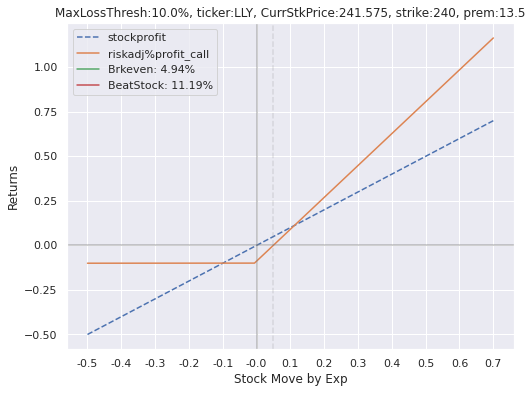

In [20]:
##### Risk-Adj Returns by Exp

def OptionRiskAdjRet(optntype, ticker, strike, prem, stockp, stockrisk, xmin, xmax):
  from matplotlib.ticker import FormatStrFormatter
  import numpy as np
  import pandas as pd
  xinc = 0.0001
  list_xticks1 = list(np.arange(xmin, xmax+xinc, xinc))
  df = pd.DataFrame(index=list_xticks1)
  df['%StockMove'] = list_xticks1
  df['StockPrice'] = stockp*(1+df['%StockMove'])

  if optntype == 'call':
    df['intrinsic'] = np.where(df['StockPrice']>strike, df['StockPrice'] - strike, 0)
    df['stockprofit'] = df['%StockMove']
    maxloss = (prem - max(0,(stockp)*(1-stockrisk) - strike)) / prem
    brkeven = -1 + ((prem + strike)/stockp)
    BeatStock = (strike + prem - stockp) / (stockp - prem/(stockrisk / maxloss))
  if optntype == 'put':
    df['intrinsic'] = np.where(df['StockPrice']<strike, strike - df['StockPrice'], 0)
    df['stockprofit'] = -1*df['%StockMove']
    maxloss = (prem - max(0,strike - (stockp)*(1+stockrisk))) / prem
    brkeven = (1 - ((prem-strike)/(-1*stockp)))*-1
    BeatStock = -1*((prem + stockp - strike) / (stockp - prem/(stockrisk / maxloss)))

  df['%profit'] = (df['intrinsic'] - prem) / prem
  df[f'riskadj%profit_{optntype}'] = df['%profit'] * (stockrisk / maxloss)
  df[f'Brkeven: {100*brkeven:.2f}%'] = np.NaN
  df[f'BeatStock: {100*BeatStock:.2f}%'] = np.NaN
  f1 = plt.figure(figsize=(8,6))
  ax1 = f1.add_subplot(1, 1, 1)
  df[['stockprofit']].plot(ax=ax1, linestyle='--',title=f'MaxLossThresh:{stockrisk*100:.1f}%, ticker:{ticker}, CurrStkPrice:{stockp}, strike:{strike}, prem:{prem}')
  df[[f'riskadj%profit_{optntype}']].plot(ax=ax1)
  df[[f'Brkeven: {100*brkeven:.2f}%']].plot(ax=ax1)
  df[[f'BeatStock: {100*BeatStock:.2f}%']].plot(ax=ax1)

  ax1.set(xlabel="Stock Move by Exp", ylabel="Returns")
  ax1.axhline(y=0, color='gray', alpha=0.5)
  ax1.axvline(x=0, color='gray', alpha=0.5)
  ax1.axvline(x=brkeven, color='gray', alpha=0.2, linestyle='--')
  
  new_ticks = np.linspace(xmin, xmax, (2+int((xmax-xmin)//0.1)))  # 0.0, 0.1, 0.2, ..., 1.0
  ax1.set_xticks(new_ticks)
  ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))



# contract4 = ('call','long', 1, 42.5, 17.4)


OptionRiskAdjRet(optntype='call', ticker='LLY', strike=240 , prem=13.5, stockp=241.575, stockrisk=0.10, xmin=-0.50, xmax=0.7)




In [3]:
### Cleaner code for plotting combination of contracts in terms of risk adj % return on capital requird

import sympy as sym
from sympy import Symbol
from sympy.solvers.inequalities import *
from sympy import UnevaluatedExpr
from sympy.solvers.inequalities import reduce_rational_inequalities
import datetime
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

############### setting up example scenario ###############

list_contracts_example_shortcallbutterfly = [('call','short', 50, 95, 6.40,'2022-03-27', 100),
                                             ('call','long', 100, 100, 3.30,'2022-03-27', 100),
                                             ('call','short', 50, 105, 1.45,'2022-03-27', 100)]

stockprice = 100

list_contracts_i = list_contracts_example_shortcallbutterfly
# interpreting a contract tuple: # (call/put, long/short, #units, strike, prem, exp, current_stock_price}

############### Identifying strategy type ###############

def get_contract_info(list_contracts): # figure out if all long, all calls, # unique strikes, etc.

  min_num_units = min([x[2] for x in list_contracts])

  list_contracts = sorted(list_contracts, 
        key=lambda x: x[3])

  list_all_strikes = sorted(list(set([x[3] for x in list_contracts])))

  ## conditions to check for all longs, all shorts, all calls, etc

  condition_all_short = (len(list_contracts) == len([x for x in list_contracts if x[1]=='short']))
  condition_all_long = (len(list_contracts) == len([x for x in list_contracts if x[1]=='long']))

  condition_all_calls = (len(list_contracts) == len([x for x in list_contracts if x[0]=='call']))
  condition_all_puts = (len(list_contracts) == len([x for x in list_contracts if x[0]=='put']))

  condition_all_strikes_same = 1 == len(set([x[3] for x in list_contracts]))
  condition_all_dates_same = 1 == len(set([x[5] for x in list_contracts]))
  condition_all_units_same = 1 == len(set([x[2] for x in list_contracts]))

  ## counting strikes, units, prems of longs, shorts, puts, calls

  number_long_call_strikes = len(set([x[3] for x in list_contracts if (x[0] == 'call') & (x[1] == 'long')]))#
  number_long_put_strikes = len(set([x[3] for x in list_contracts if (x[0] == 'put') & (x[1] == 'long')]))#

  number_short_call_strikes = len(set([x[3] for x in list_contracts if (x[0] == 'call') & (x[1] == 'short')]))#
  number_short_put_strikes = len(set([x[3] for x in list_contracts if (x[0] == 'put') & (x[1] == 'short')]))#

  number_long_call_units = sum([x[2] for x in list_contracts if (x[0] == 'call') & (x[1] == 'long')])
  number_long_put_units = sum([x[2] for x in list_contracts if (x[0] == 'put') & (x[1] == 'long')])

  number_short_call_units = sum([x[2] for x in list_contracts if (x[0] == 'call') & (x[1] == 'short')])
  number_short_put_units = sum([x[2] for x in list_contracts if (x[0] == 'put') & (x[1] == 'short')])

  ## listing strikes, prems, and units

  list_call_prems = [x[4] for x in list_contracts if (x[0] == 'call')]
  list_put_prems = [x[4] for x in list_contracts if (x[0] == 'put')]

  list_long_call_strikes = [x[3] for x in list_contracts if (x[0] == 'call') & (x[1] == 'long')]
  list_long_put_strikes = [x[3] for x in list_contracts if (x[0] == 'put') & (x[1] == 'long')]
  list_short_call_strikes = [x[3] for x in list_contracts if (x[0] == 'call') & (x[1] == 'short')]
  list_short_put_strikes = [x[3] for x in list_contracts if (x[0] == 'put') & (x[1] == 'short')]

  list_long_call_prems = [x[4] for x in list_contracts if (x[0] == 'call') & (x[1] == 'long')]
  list_long_put_prems = [x[4] for x in list_contracts if (x[0] == 'put') & (x[1] == 'long')]
  list_short_call_prems = [x[4] for x in list_contracts if (x[0] == 'call') & (x[1] == 'short')]
  list_short_put_prems = [x[4] for x in list_contracts if (x[0] == 'put') & (x[1] == 'short')]

  list_long_call_units = [x[2] for x in list_contracts if (x[0] == 'call') & (x[1] == 'long')]
  list_long_put_units = [x[2] for x in list_contracts if (x[0] == 'put') & (x[1] == 'long')]
  list_short_call_units = [x[2] for x in list_contracts if (x[0] == 'call') & (x[1] == 'short')]
  list_short_put_units = [x[2] for x in list_contracts if (x[0] == 'put') & (x[1] == 'short')]

def get_strategy_type():

  condition_long_call = (condition_all_calls==1) & (condition_all_long==1) & (condition_all_units_same==1) & (condition_all_strikes_same==1) & (condition_all_dates_same==1)
  condition_long_put = (condition_all_puts==1) & (condition_all_long==1) & (condition_all_units_same==1) & (condition_all_strikes_same==1) & (condition_all_dates_same==1)

  condition_short_call_naked = (condition_all_calls==1) & (condition_all_short==1) & (condition_all_units_same==1) & (condition_all_strikes_same==1) & (condition_all_dates_same==1)
  condition_long_straddle = (condition_all_calls==0) & (condition_all_long==1) & (condition_all_units_same==1) & (condition_all_strikes_same==1) & (condition_all_dates_same==1)

  if condition_long_call==1: strategy_type = 'long_call'
  if condition_long_put==1: strategy_type = 'long_put'
  if condition_short_call_naked==1: strategy_type = 'short_call_naked'
  if condition_long_straddle==1: strategy_type = 'long_straddle'

  if (len(list_long_call_strikes)>=1) & (len(list_long_put_strikes)>=1):
    condition_long_strangle = (condition_all_calls==0) & (condition_all_long==1) & (condition_all_units_same==1) & (list_long_call_strikes[0] > list_long_put_strikes[0] ) & (condition_all_dates_same==1)
    if condition_long_strangle==1: strategy_type = 'long_strangle'

  if (len(list_short_call_strikes)>=1) & (len(list_short_put_strikes)>=1):
    condition_short_straddle = (condition_all_calls==0) & (condition_all_short==1) & (condition_all_units_same==1) & (condition_all_strikes_same==1) & (condition_all_dates_same==1)
    if condition_short_straddle==1: strategy_type = 'short_strangle'

  if (number_all_strikes==3) & (condition_all_dates_same): # & condition_all_dates_same==True:
    low_strike = list_all_strikes[0]
    middle_strike = list_all_strikes[1]
    high_strike = list_all_strikes[2]

    len1 = sum([x[2] for x in list_contracts if (x[3]==middle_strike)])
    len2 =  sum([x[2] for x in list_contracts if (x[3]==high_strike)])

    condition_units_middle_double_lower = (sum([x[2] for x in list_contracts if (x[3]==middle_strike)]) == 2*sum([x[2] for x in list_contracts if (x[3]==low_strike)]))
    condition_units_middle_double_higher = (sum([x[2] for x in list_contracts if (x[3]==middle_strike)]) == 2*sum([x[2] for x in list_contracts if (x[3]==high_strike)]))
    condition_units_middle_double_outer = (condition_units_middle_double_lower & condition_units_middle_double_higher) == 1
    condition_short_middle = list_contracts[1]=='a' # (len(list_contracts) == len([x for x in list_contracts if x[1]=='short']))

    print(f'condition_units_middle_double_outer:{condition_units_middle_double_outer}, should be true')
    print(f'condition_all_puts:{condition_all_puts}, should be true')
    print(f'number_all_strikes:{number_all_strikes}, should be 3')

    # print(f'(sum([x[2] for x in list_contracts if (x[3]==middle_strike)]) == 2*sum([x[2] for x in list_contracts if ((x[3]==low_strike))])):{(sum([x[2] for x in list_contracts if (x[3]==middle_strike)]) == 2*sum([x[2] for x in list_contracts if ((x[3]==low_strike))]))}')

    if ((condition_all_calls) | (condition_all_puts)) & (condition_units_middle_double_outer):

      condition_units_middle_double_lower = (sum([x[2] for x in list_contracts if (x[3]==middle_strike)]) == 2*sum([x[2] for x in list_contracts if (x[3]==low_strike)]))
      condition_units_middle_double_higher = (sum([x[2] for x in list_contracts if (x[3]==middle_strike)]) == 2*sum([x[2] for x in list_contracts if (x[3]==high_strike)]))
      condition_units_middle_double_outer = (condition_units_middle_double_lower & condition_units_middle_double_higher) == 1
      
      condition_short_middle = len([x for x in list_contracts if ((x[3]==middle_strike) & (x[1]=='short'))]) == 1
      condition_long_low = len([x for x in list_contracts if ((x[3]==low_strike) & (x[1]=='long'))]) == 1
      condition_long_high = len([x for x in list_contracts if ((x[3]==high_strike) & (x[1]=='long'))]) == 1

      condition_long_call_butterfly = (condition_units_middle_double_outer) & (condition_all_calls==1) & (number_all_strikes==3) & (condition_short_middle==1) & (condition_long_low==1 & condition_long_high==1) & (condition_all_dates_same==1)  # need to sort list of strikes #
      condition_short_call_butterfly = (condition_units_middle_double_outer) & (condition_all_calls==1) & (number_all_strikes==3) & (condition_short_middle==0) & (condition_long_low==0 & condition_long_high==0) & (condition_all_dates_same==1)  # need to sort list of strikes #

      condition_long_put_butterfly = (condition_units_middle_double_outer) & (condition_all_puts==1) & (number_all_strikes==3) & (condition_short_middle==1) & (condition_long_low==1) & (condition_long_high==1) & (condition_all_dates_same==1)  # need to sort list of strikes #
      condition_short_put_butterfly = (condition_units_middle_double_outer) & (condition_all_puts==1) & (number_all_strikes==3) & (condition_short_middle==0) & (condition_long_low==0) & (condition_long_high==0) & (condition_all_dates_same==1)  # need to sort list of strikes #

      if condition_long_call_butterfly==1: strategy_type = 'long_call_butterfly'
      if condition_short_call_butterfly==1: strategy_type = 'short_call_butterfly'
      if condition_long_put_butterfly==1: strategy_type = 'long_put_butterfly'
      if condition_short_put_butterfly==1: strategy_type = 'short_put_butterfly'

  if number_all_strikes==2 & ((condition_all_calls) | (condition_all_puts)) & (condition_all_long==0):
    
    condition_bull_call_spr = condition_all_calls & (list_long_call_strikes[0] < list_short_call_strikes[0]) & (number_long_call_units == number_short_call_units) & (condition_all_dates_same==1)
    condition_bull_put_spr = condition_all_puts & (list_long_put_strikes[0] < list_short_put_strikes[0]) & (number_long_put_units == number_short_put_units) & (condition_all_dates_same==1)

    condition_bear_call_spr = condition_all_calls & (list_long_call_strikes[0] > list_short_call_strikes[0]) & (number_long_call_units == number_short_call_units) & (condition_all_dates_same==1)
    condition_bear_put_spr = condition_all_puts & (list_long_put_strikes[0] > list_short_put_strikes[0]) & (number_long_put_units == number_short_put_units) & (condition_all_dates_same==1)

    if condition_bull_call_spr==1: strategy_type = 'bull_call_spr'
    if condition_bull_put_spr==1: strategy_type = 'bull_put_spr'
    if condition_bear_call_spr==1: strategy_type = 'bear_call_spr'
    if condition_bear_put_spr==1: strategy_type = 'bear_put_spr'
    
    # list_long_call_strikes[0]

  print(f'Strategy type: {strategy_type}')

def get_margin_req():

  if strategy_type == 'long_call': 
    margin_req_initial = 100*number_long_call_units * list_call_prems[0]

  if strategy_type == 'short_call_naked': 
    margin_req_initial = 100*max((0.2*list_contracts[0][6]*number_short_call_units) - max(list_short_call_strikes[0] - list_contracts[0][6], 0)*number_short_call_units + (list_contracts[0][4])*number_short_call_units, (0.1*list_contracts[0][6]*number_short_call_units) + (list_contracts[0][4]*number_short_call_units), 2.50*number_short_call_units)

  if strategy_type == 'long_put': 
    margin_req_initial = 100*number_long_put_units * list_put_prems[0]

  if strategy_type == 'short_put_naked': 
    margin_req_initial = 100*max((0.2*list_contracts[0][6]*number_short_put_units) - max(list_contracts[0][6] - list_short_put_strikes[0], 0)*number_short_put_units + (list_contracts[0][4])*number_short_put_units, (0.1*list_contracts[0][6]*number_short_put_units) + (list_contracts[0][4]*number_short_put_units), 2.50*number_short_put_units)

  if (strategy_type == 'long_straddle') | (strategy_type == 'long_strangle'): 
    margin_req_initial = 100*(number_long_call_units * list_call_prems[0]) + 100*(number_long_put_units * list_put_prems[0])

  if (strategy_type == 'short_straddle') | (strategy_type == 'short_strangle'): 
    margin_req_initial_short_call = 100*max((0.2*list_contracts[0][6]*number_short_call_units) - max(list_short_call_strikes[0] - list_contracts[0][6], 0)*number_short_call_units + (list_contracts[0][4])*number_short_call_units, (0.1*list_contracts[0][6]*number_short_call_units) + (list_contracts[0][4]*number_short_call_units), 2.50*number_short_call_units)
    margin_req_initial_short_put = 100*max((0.2*list_contracts[0][6]*number_short_put_units) - max(list_contracts[0][6] - list_short_put_strikes[0], 0)*number_short_put_units + (list_contracts[0][4])*number_short_put_units, (0.1*list_contracts[0][6]*number_short_put_units) + (list_contracts[0][4]*number_short_put_units), 2.50*number_short_put_units)
    
    if margin_req_initial_short_call >= margin_req_initial_short_put: 
      margin_req_initial = 100*margin_req_initial_short_call + (number_short_put_units * list_put_prems[0])
    
    if margin_req_initial_short_call < margin_req_initial_short_put: 
      margin_req_initial = 100*margin_req_initial_short_put + (number_short_call_units * list_call_prems[0])

  if strategy_type == 'long_call_butterfly': 
    margin_req_initial = 100*(list_long_call_units[0]*list_long_call_prems[0] + list_long_call_units[1]*list_long_call_prems[1]) - (list_short_call_units[0]*list_short_call_prems[0])

  if strategy_type == 'long_put_butterfly': 
    margin_req_initial = 100*(list_long_put_units[0]*list_long_put_prems[0] + list_long_put_units[1]*list_long_put_prems[1]) - (list_short_put_units[0]*list_short_put_prems[0])

  if strategy_type == 'short_call_butterfly': 
    margin_req_initial = 100*(middle_strike - low_strike)*list_short_call_units[0]
    print('margin_req_initial = (middle_strike - low_strike)*number_of_shortcalls')
    print(f'margin_req_initial:{margin_req_initial}')

  if strategy_type == 'short_put_butterfly': 
    margin_req_initial = 100*(high_strike - middle_strike)*list_short_put_units[0]
    print('margin_req_initial = (high_strike - middle_strike)*number_of_shortputs')
    print(f'margin_req_initial:{margin_req_initial}')

def get_max_gain_and_loss():

  if strategy_type == 'long_call': 
    max_loss_nominal, max_gain_nominal = margin_req_initial, np.inf
    max_loss_pct, max_gain_pct = max_loss_nominal/margin_req_initial, max_gain_nominal/margin_req_initial

  if strategy_type == 'short_call_naked': 
    max_loss_nominal, max_gain_nominal = np.inf, 100*sum([a*b for a,b in zip(list_long_call_units,list_long_call_prems)])
    max_loss_pct, max_gain_pct = max_loss_nominal/margin_req_initial, max_gain_nominal/margin_req_initial

  if strategy_type == 'long_put': 
    max_loss_nominal, max_gain_nominal = margin_req_initial, np.inf
    max_loss_pct, max_gain_pct = max_loss_nominal/margin_req_initial, max_gain_nominal/margin_req_initial

  if strategy_type == 'short_put_naked': 
    max_loss_nominal, max_gain_nominal = np.inf, 100*sum([a*b for a,b in zip(list_long_put_units,list_long_put_prems)])
    max_loss_pct, max_gain_pct = max_loss_nominal/margin_req_initial, max_gain_nominal/margin_req_initial

  if strategy_type == 'long_straddle': 
    max_loss_nominal, max_gain_nominal = margin_req_initial, np.inf
    max_loss_pct, max_gain_pct = max_loss_nominal/margin_req_initial, max_gain_nominal/margin_req_initial

      
  if strategy_type == 'short_straddle':
    max_loss_nominal, max_gain_nominal = np.inf, 100*sum([a*b for a,b in zip(list_short_put_units,list_short_put_prems)]) + 100*sum([a*b for a,b in zip(list_short_call_units,list_short_call_prems)])
    max_loss_pct, max_gain_pct = max_loss_nominal/margin_req_initial, max_gain_nominal/margin_req_initial
    # if (strategy_type == 'long_straddle') | (strategy_type == 'long_strangle'): 
    # margin_req_initial = 100*(number_long_call_units * list_call_prems[0]) + 100*(number_long_put_units * list_put_prems[0])

  print(f'''max_loss_nominal:{max_loss_nominal}, max_gain_nominal:{max_gain_nominal}, 
  max_loss_pct:{max_loss_pct}, max_gain_pct:{max_gain_pct}''')  
  
    # margin_req_initial
    
    # list_long_call_units[0]*list_long_call_prems[0]
    # max_loss_pct, max_gain_pct = xxxxxx


In [4]:
print(np.inf)

inf


3

condition_all_callsTrue
condition_all_longFalse
condition_all_units_sameFalse
condition_all_strikes_sameFalse
condition_all_dates_sameTrue
      
number_all_strikes:3
condition_all_dates_same:True
len(list_all_strikes):3
[95, 100, 105]
len1:100
len2:50
condition_units_middle_double_outer:True, should be true
condition_all_puts:False, should be true
number_all_strikes:3, should be 3
(sum([x[2] for x in list_contracts if (x[3]==middle_strike)]) == 2*sum([x[2] for x in list_contracts if ((x[3]==low_strike))])):True
condition_short_middle:False, should be false
condition_long_low:False, should be false
condition_long_high:False, should be false
condition_all_dates_same:True, should be true
((condition_all_calls) | (condition_all_puts)):True
Strategy type: short_call_butterfly
margin_req_initial = (middle_strike - low_strike)*number_of_shortcalls
margin_req_initial:25000
Name:contract1_shortcall*50_95str6.4prem 
 -25*x - 25*Abs(x - 95) + 2695.0
Name:contract2_longcall*100_100str3.3prem 


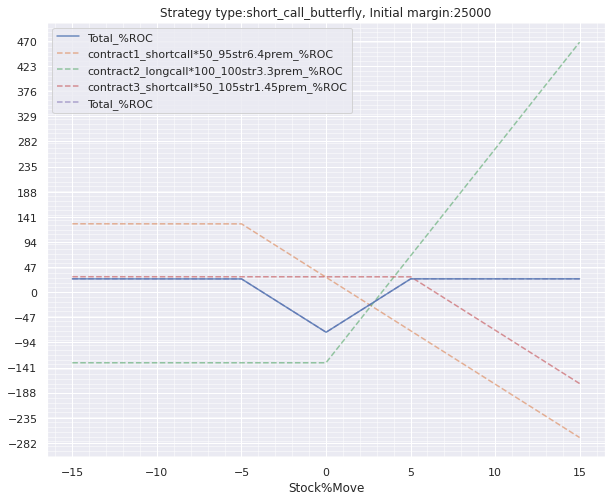

In [5]:
#### PnL Diagram with multiple contracts and custom gridline. 
import sympy as sym
from sympy import Symbol
from sympy.solvers.inequalities import *
from sympy import UnevaluatedExpr
from sympy.solvers.inequalities import reduce_rational_inequalities
import datetime
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

#### put sprad collar example
# type, LongOrShort, NumUnits, strike, prem, exp('YYYY-MM-DD'), UnderlyingPrice
# stockprice = 1172.00 # oct11 close price of TSLA. Assume Nov19 expiration. Use bberg data. 
# contract1 = ('call','long', 1, 0, stockprice) ### 100 shares of stock, long
# contract2 = ('call','short', 1, 120, 1.3)
# contract3 = ('put','long', 1, 805, 50.95)
# contract4 = ('put','long', 1, 1000, 40.5,'2021-12-20', 957)
# contract5 = ('put','short', 1, 940, 27.4,'2021-12-20', 957)


strategy_type = 0

# contract6 = ('call','long', 50, 240, 13.5,'2022-03-27', 241.575)
# contract7 = ('put','long', 50, 240, 12.8,'2022-03-27', 241.575)
# stockprice = 241.575
# list_contracts = [contract6,contract7]

contract8 = ('call','short', 50, 95, 6.40,'2022-03-27', 100)
contract9 = ('call','long', 100, 100, 3.30,'2022-03-27', 100)
contract10 = ('call','short', 50, 105, 1.45,'2022-03-27', 100)
stockprice = 100
list_contracts = [contract8, contract9, contract10]

# Sell 1 XYZ 95 call at 6.40	6.40
# Buy 2 XYZ 100 calls at 3.30 each
# Sell 1 XYZ 105 call at 1.45

# contract8 = ('put','short', 3, 75, 6.40,'2022-03-27', 80)
# contract9 = ('put','long', 6, 80, 4.00,'2022-03-27', 80)
# contract10 = ('put','short', 3, 85, 6.00,'2022-03-27', 80)
# stockprice = 80
# Sell to open 3 Mar 75 puts at $1.50
# Buy to open 6 Mar 80 puts at $4.00
# Sell to open 3 Mar 85 puts at $6.00

graph_style = 'ROC_riskadj' # , 'PnL' # or ROC_riskadj # return on capital

# list_contracts = [contract8, contract9, contract10]
# list_contracts = [contract6,contract7]

min_num_units = min([x[2] for x in list_contracts])

MaxMove = 0.15 # min value of x axis is stockprice(1-MaxMove). Max is stockprice(1+MaxMove)
Increments = 5000 # how many datapts to plot in the figure (granularity)

xmajorspace = stockprice//10
xminorspace = stockprice//50
ymajorspace = min_num_units*stockprice*100//5 # do not use min num units if plotting %
yminorspace = min_num_units*stockprice*100//25

### First, check number of unique strikes and whether all contracts are long or short
## straddle has one unique strike, and an equal number of long calls and long puts. all contracts are long
## ratio straddle has one unique strike, but an unequal number of long calls and puts. all contracts are long 
## strangle has two unique strikes, the call strike is above the put strike, both are long. all contracts are long

## when considering the return, consider what the margin requirements would be at start *and* end
## it may get worse as price moves higher, if so we should consider that when calculating % return

#### Sorting list of contracts by strike

list_contracts = sorted(list_contracts, 
       key=lambda x: x[3])

list_all_strikes = sorted(list(set([x[3] for x in list_contracts])))

condition_all_short = (len(list_contracts) == len([x for x in list_contracts if x[1]=='short']))
condition_all_long = (len(list_contracts) == len([x for x in list_contracts if x[1]=='long']))

condition_all_calls = (len(list_contracts) == len([x for x in list_contracts if x[0]=='call']))
condition_all_puts = (len(list_contracts) == len([x for x in list_contracts if x[0]=='put']))

condition_all_strikes_same = 1 == len(set([x[3] for x in list_contracts]))
condition_all_dates_same = 1 == len(set([x[5] for x in list_contracts]))
condition_all_units_same = 1 == len(set([x[2] for x in list_contracts]))

# condition_long_straddle = (condition_all_calls==0) & (condition_all_long==1) & (condition_all_units_same==1) & (condition_all_strikes_same==1) & (condition_all_dates_same==1)

number_all_strikes = len(set([x[3] for x in list_contracts])) # number of unique strikes 

print(number_all_strikes)

number_long_call_strikes = len(set([x[3] for x in list_contracts if (x[0] == 'call') & (x[1] == 'long')]))#
number_long_put_strikes = len(set([x[3] for x in list_contracts if (x[0] == 'put') & (x[1] == 'long')]))#

number_short_call_strikes = len(set([x[3] for x in list_contracts if (x[0] == 'call') & (x[1] == 'short')]))#
number_short_put_strikes = len(set([x[3] for x in list_contracts if (x[0] == 'put') & (x[1] == 'short')]))#

number_long_call_units = sum([x[2] for x in list_contracts if (x[0] == 'call') & (x[1] == 'long')])
number_long_put_units = sum([x[2] for x in list_contracts if (x[0] == 'put') & (x[1] == 'long')])

number_short_call_units = sum([x[2] for x in list_contracts if (x[0] == 'call') & (x[1] == 'short')])
number_short_put_units = sum([x[2] for x in list_contracts if (x[0] == 'put') & (x[1] == 'short')])

list_call_prems = [x[4] for x in list_contracts if (x[0] == 'call')]
list_put_prems = [x[4] for x in list_contracts if (x[0] == 'put')]

list_long_call_strikes = [x[3] for x in list_contracts if (x[0] == 'call') & (x[1] == 'long')]
list_long_put_strikes = [x[3] for x in list_contracts if (x[0] == 'put') & (x[1] == 'long')]
list_short_call_strikes = [x[3] for x in list_contracts if (x[0] == 'call') & (x[1] == 'short')]
list_short_put_strikes = [x[3] for x in list_contracts if (x[0] == 'put') & (x[1] == 'short')]

list_long_call_prems = [x[4] for x in list_contracts if (x[0] == 'call') & (x[1] == 'long')]
list_long_put_prems = [x[4] for x in list_contracts if (x[0] == 'put') & (x[1] == 'long')]
list_short_call_prems = [x[4] for x in list_contracts if (x[0] == 'call') & (x[1] == 'short')]
list_short_put_prems = [x[4] for x in list_contracts if (x[0] == 'put') & (x[1] == 'short')]

list_long_call_units = [x[2] for x in list_contracts if (x[0] == 'call') & (x[1] == 'long')]
list_long_put_units = [x[2] for x in list_contracts if (x[0] == 'put') & (x[1] == 'long')]
list_short_call_units = [x[2] for x in list_contracts if (x[0] == 'call') & (x[1] == 'short')]
list_short_put_units = [x[2] for x in list_contracts if (x[0] == 'put') & (x[1] == 'short')]


### Trade types

condition_long_call = (condition_all_calls==1) & (condition_all_long==1) & (condition_all_units_same==1) & (condition_all_strikes_same==1) & (condition_all_dates_same==1)
condition_long_put = (condition_all_puts==1) & (condition_all_long==1) & (condition_all_units_same==1) & (condition_all_strikes_same==1) & (condition_all_dates_same==1)

condition_short_call_naked = (condition_all_calls==1) & (condition_all_short==1) & (condition_all_units_same==1) & (condition_all_strikes_same==1) & (condition_all_dates_same==1)
condition_long_straddle = (condition_all_calls==0) & (condition_all_long==1) & (condition_all_units_same==1) & (condition_all_strikes_same==1) & (condition_all_dates_same==1)

print(f"""
condition_all_calls{condition_all_calls}
condition_all_long{condition_all_long}
condition_all_units_same{condition_all_units_same}
condition_all_strikes_same{condition_all_strikes_same}
condition_all_dates_same{condition_all_dates_same}
      """)

if condition_long_call==1: strategy_type = 'long_call'
if condition_long_put==1: strategy_type = 'long_put'
if condition_short_call_naked==1: strategy_type = 'short_call_naked'
if condition_long_straddle==1: strategy_type = 'long_straddle'

if (len(list_long_call_strikes)>=1) & (len(list_long_put_strikes)>=1):
  condition_long_strangle = (condition_all_calls==0) & (condition_all_long==1) & (condition_all_units_same==1) & (list_long_call_strikes[0] > list_long_put_strikes[0] ) & (condition_all_dates_same==1)
  if condition_long_strangle==1: strategy_type = 'long_strangle'

if (len(list_short_call_strikes)>=1) & (len(list_short_put_strikes)>=1):
  condition_short_straddle = (condition_all_calls==0) & (condition_all_short==1) & (condition_all_units_same==1) & (condition_all_strikes_same==1) & (condition_all_dates_same==1)
  if condition_short_straddle==1: strategy_type = 'short_strangle'
  
# condition_short_straddle = (condition_all_calls==0) & (condition_all_short==1) & (condition_all_units_same==1) & (condition_all_strikes_same==1) & (condition_all_dates_same==1)
# condition_short_strangle = (condition_all_calls==0) & (condition_all_short==1) & (condition_all_units_same==1) & (list_short_call_strikes[0] > list_short_put_strikes[0] ) & (condition_all_dates_same==1)

print(f'number_all_strikes:{number_all_strikes}')
print(f'condition_all_dates_same:{condition_all_dates_same}')
print(f'len(list_all_strikes):{len(list_all_strikes)}')

if (number_all_strikes==3) & (condition_all_dates_same): # & condition_all_dates_same==True:
  low_strike = list_all_strikes[0]
  middle_strike = list_all_strikes[1]
  high_strike = list_all_strikes[2]
  print(list_all_strikes)

  len1 = sum([x[2] for x in list_contracts if (x[3]==middle_strike)])
  len2 =  sum([x[2] for x in list_contracts if (x[3]==high_strike)])

  print(f'len1:{len1}')
  print(f'len2:{len2}')

  condition_units_middle_double_lower = (sum([x[2] for x in list_contracts if (x[3]==middle_strike)]) == 2*sum([x[2] for x in list_contracts if (x[3]==low_strike)]))
  condition_units_middle_double_higher = (sum([x[2] for x in list_contracts if (x[3]==middle_strike)]) == 2*sum([x[2] for x in list_contracts if (x[3]==high_strike)]))
  condition_units_middle_double_outer = (condition_units_middle_double_lower & condition_units_middle_double_higher) == 1
  condition_short_middle = list_contracts[1]=='a' # (len(list_contracts) == len([x for x in list_contracts if x[1]=='short']))

  print(f'condition_units_middle_double_outer:{condition_units_middle_double_outer}, should be true')
  print(f'condition_all_puts:{condition_all_puts}, should be true')
  print(f'number_all_strikes:{number_all_strikes}, should be 3')


  print(f'(sum([x[2] for x in list_contracts if (x[3]==middle_strike)]) == 2*sum([x[2] for x in list_contracts if ((x[3]==low_strike))])):{(sum([x[2] for x in list_contracts if (x[3]==middle_strike)]) == 2*sum([x[2] for x in list_contracts if ((x[3]==low_strike))]))}')
# (sum([x[2] for x in list_contracts if (x[3]==middle_strike)]) == 2*sum([x[2] for x in list_contracts if ((x[3]==low_strike))]))
  if ((condition_all_calls) | (condition_all_puts)) & (condition_units_middle_double_outer):

    # condition_units_middle_double_lower = (sum([x[2] for x in list_contracts if (x[3]==middle_strike)]) == 2*sum([x[2] for x in list_contracts if (x[3]==low_strike)]))
    # condition_units_middle_double_higher = (sum([x[2] for x in list_contracts if (x[3]==middle_strike)]) == 2*sum([x[2] for x in list_contracts if (x[3]==high_strike)]))
    # condition_units_middle_double_outer = (condition_units_middle_double_lower & condition_units_middle_double_higher) == 1
    
    condition_short_middle = len([x for x in list_contracts if ((x[3]==middle_strike) & (x[1]=='short'))]) == 1
    condition_long_low = len([x for x in list_contracts if ((x[3]==low_strike) & (x[1]=='long'))]) == 1
    condition_long_high = len([x for x in list_contracts if ((x[3]==high_strike) & (x[1]=='long'))]) == 1

    condition_long_call_butterfly = (condition_units_middle_double_outer) & (condition_all_calls==1) & (number_all_strikes==3) & (condition_short_middle==1) & (condition_long_low==1 & condition_long_high==1) & (condition_all_dates_same==1)  # need to sort list of strikes #
    condition_short_call_butterfly = (condition_units_middle_double_outer) & (condition_all_calls==1) & (number_all_strikes==3) & (condition_short_middle==0) & (condition_long_low==0 & condition_long_high==0) & (condition_all_dates_same==1)  # need to sort list of strikes #

    condition_long_put_butterfly = (condition_units_middle_double_outer) & (condition_all_puts==1) & (number_all_strikes==3) & (condition_short_middle==1) & (condition_long_low==1) & (condition_long_high==1) & (condition_all_dates_same==1)  # need to sort list of strikes #
    condition_short_put_butterfly = (condition_units_middle_double_outer) & (condition_all_puts==1) & (number_all_strikes==3) & (condition_short_middle==0) & (condition_long_low==0) & (condition_long_high==0) & (condition_all_dates_same==1)  # need to sort list of strikes #
      
    print(f'condition_short_middle:{condition_short_middle}, should be false')
    print(f'condition_long_low:{condition_long_low}, should be false')
    print(f'condition_long_high:{condition_long_high}, should be false')
    print(f'condition_all_dates_same:{condition_all_dates_same}, should be true')
    print(f'((condition_all_calls) | (condition_all_puts)):{((condition_all_calls) | (condition_all_puts))}')
    

    if condition_long_call_butterfly==1: strategy_type = 'long_call_butterfly'
    if condition_short_call_butterfly==1: strategy_type = 'short_call_butterfly'
    if condition_long_put_butterfly==1: strategy_type = 'long_put_butterfly'
    if condition_short_put_butterfly==1: strategy_type = 'short_put_butterfly'

  if number_all_strikes==2 & ((condition_all_calls) | (condition_all_puts)) & (condition_all_long==0):
    
    condition_bull_call_spr = condition_all_calls & (list_long_call_strikes[0] < list_short_call_strikes[0]) & (number_long_call_units == number_short_call_units) & (condition_all_dates_same==1)
    condition_bull_put_spr = condition_all_puts & (list_long_put_strikes[0] < list_short_put_strikes[0]) & (number_long_put_units == number_short_put_units) & (condition_all_dates_same==1)

    condition_bear_call_spr = condition_all_calls & (list_long_call_strikes[0] > list_short_call_strikes[0]) & (number_long_call_units == number_short_call_units) & (condition_all_dates_same==1)
    condition_bear_put_spr = condition_all_puts & (list_long_put_strikes[0] > list_short_put_strikes[0]) & (number_long_put_units == number_short_put_units) & (condition_all_dates_same==1)

    if condition_bull_call_spr==1: strategy_type = 'bull_call_spr'
    if condition_bull_put_spr==1: strategy_type = 'bull_put_spr'
    if condition_bear_call_spr==1: strategy_type = 'bear_call_spr'
    if condition_bear_put_spr==1: strategy_type = 'bear_put_spr'
    

    # list_long_call_strikes[0]

print(f'Strategy type: {strategy_type}')

#### ADJUST THIS LINE

# condition_intercept = (df['Total_profit'].abs()<0.03)
# It needs to scale based on the resolution of the x increments we use when plotting.

### Dictionary of margin requirements. 
# type, LongOrShort, NumUnits, strike, prem, exp('YYYY-MM-DD'), UnderlyingPrice

# https://tastyworks.freshdesk.com/support/solutions/folders/43000342979/page/2?_sp=b4a89671-4748-44bc-82a5-e08ad811217b.1641917270574&url_locale=
# alternate source: https://td.intelliresponse.com/tddirectinvesting/public/index.jsp?requestType=NormalRequest&id=8379&question=What+are+the+margin+requirements+for+options

if strategy_type == 'long_call': 
  margin_req_initial = 100*number_long_call_units * list_call_prems[0]

if strategy_type == 'short_call_naked': 
  margin_req_initial = 100*max((0.2*list_contracts[0][6]*number_short_call_units) - max(list_short_call_strikes[0] - list_contracts[0][6], 0)*number_short_call_units + (list_contracts[0][4])*number_short_call_units, (0.1*list_contracts[0][6]*number_short_call_units) + (list_contracts[0][4]*number_short_call_units), 2.50*number_short_call_units)

if strategy_type == 'long_put': 
  margin_req_initial = 100*number_long_put_units * list_put_prems[0]

if strategy_type == 'short_put_naked': 
  margin_req_initial = 100*max((0.2*list_contracts[0][6]*number_short_put_units) - max(list_contracts[0][6] - list_short_put_strikes[0], 0)*number_short_put_units + (list_contracts[0][4])*number_short_put_units, (0.1*list_contracts[0][6]*number_short_put_units) + (list_contracts[0][4]*number_short_put_units), 2.50*number_short_put_units)

if (strategy_type == 'long_straddle') | (strategy_type == 'long_strangle'): 
  margin_req_initial = 100*(number_long_call_units * list_call_prems[0]) + 100*(number_long_put_units * list_put_prems[0])

if (strategy_type == 'short_straddle') | (strategy_type == 'short_strangle'): 
  margin_req_initial_short_call = 100*max((0.2*list_contracts[0][6]*number_short_call_units) - max(list_short_call_strikes[0] - list_contracts[0][6], 0)*number_short_call_units + (list_contracts[0][4])*number_short_call_units, (0.1*list_contracts[0][6]*number_short_call_units) + (list_contracts[0][4]*number_short_call_units), 2.50*number_short_call_units)
  margin_req_initial_short_put = 100*max((0.2*list_contracts[0][6]*number_short_put_units) - max(list_contracts[0][6] - list_short_put_strikes[0], 0)*number_short_put_units + (list_contracts[0][4])*number_short_put_units, (0.1*list_contracts[0][6]*number_short_put_units) + (list_contracts[0][4]*number_short_put_units), 2.50*number_short_put_units)
  
  if margin_req_initial_short_call >= margin_req_initial_short_put: 
    margin_req_initial = 100*margin_req_initial_short_call + (number_short_put_units * list_put_prems[0])
  
  if margin_req_initial_short_call < margin_req_initial_short_put: 
    margin_req_initial = 100*margin_req_initial_short_put + (number_short_call_units * list_call_prems[0])

if strategy_type == 'long_call_butterfly': 
  margin_req_initial = 100*(list_long_call_units[0]*list_long_call_prems[0] + list_long_call_units[1]*list_long_call_prems[1]) - (list_short_call_units[0]*list_short_call_prems[0])

if strategy_type == 'long_put_butterfly': 
  margin_req_initial = 100*(list_long_put_units[0]*list_long_put_prems[0] + list_long_put_units[1]*list_long_put_prems[1]) - (list_short_put_units[0]*list_short_put_prems[0])

if strategy_type == 'short_call_butterfly': 
  margin_req_initial = 100*(middle_strike - low_strike)*list_short_call_units[0]
  print('margin_req_initial = (middle_strike - low_strike)*number_of_shortcalls')
  print(f'margin_req_initial:{margin_req_initial}')

if strategy_type == 'short_put_butterfly': 
  margin_req_initial = 100*(high_strike - middle_strike)*list_short_put_units[0]
  print('margin_req_initial = (high_strike - middle_strike)*number_of_shortputs')
  print(f'margin_req_initial:{margin_req_initial}')

# low_strike = list_all_strikes[0]
# middle_strike = list_all_strikes[1]
# high_strike = list_all_strikes[2]

# condition_long_call_butterfly

# dict_margin_reqs_initial = {} # example key 'long_call'

# dict_margin_reqs_maint = {}

# dict_margin_reqs_initial['long_call'] = number_long_call_units * list_call_prems[0]
# dict_margin_reqs_maint['long_call'] = number_long_call_units * list_call_prems[0]

# dict_margin_reqs_initial['short_call_naked'] = max((0.2*list_contracts[0][6]*number_short_call_units) - (list_contracts[0][6] - list_short_call_strikes[0])*number_short_call_units + (list_contracts[0][4])*number_short_call_units, (0.1*list_contracts[0][6]*number_short_call_units) + (list_contracts[0][4]*number_short_call_units), (list_contracts[0][4] + 1)*number_short_call_units)
# #max of: 20% of the underlying price minus the out-of-the-money amount plus the option premium
# # 10% of the underlying price plus the option premium
# # $2.50
# dict_margin_reqs_maint['short_call_naked'] = max((0.2*list_contracts[0][6]*number_short_call_units) - (list_contracts[0][6] - list_short_call_strikes[0])*number_short_call_units + (list_contracts[0][4])*number_short_call_units, (0.1*list_contracts[0][6]*number_short_call_units) + (list_contracts[0][4]*number_short_call_units), (list_contracts[0][4] + 1)*number_short_call_units)

# # Market value of the option + (20% of the Underlying Market Value) – (OTM Value)
# # Market value of the option + (10% of the Underlying Market Value)
# # Market value of the option + ($100/contract)
# ### Building in margin requirements. Show PnL as a % of capital used, as well as a % of max loss. 
# ############################


# # L1C_s100p22_e18Dec2021# long 1 call with strike of 100, premium of 22, that expires on 18th of dec. 2021
# # margin requirements are here: https://www.tradestation.com/pricing/options-margin-requirements/

# # print(test_sum)

# #########################################

x = Symbol('x', real=True)

def MaxToAbs(param1, param2):
  return ((param1 + param2 + Abs(param1-param2)) / 2)

Width = ((stockprice*(1+MaxMove)) - (stockprice*(1-MaxMove)))/Increments

list_xvals = [stockprice*(1-MaxMove) + x*Width for x in range(Increments)]

list_profitformulas = []

df = pd.DataFrame()
df['StockPrice'] = list_xvals
df['Stock%Move'] = 100*((df['StockPrice']/stockprice) - 1)

for num, contract in enumerate(list_contracts, start=1):
  Type = contract[0]
  if contract[1]=='long': LongOrShort = 1
  if contract[1]=='short': LongOrShort = -1
  NumUnits = contract[2]
  Strike = contract[3]
  Prem = contract[4]
  name = f'contract{num}_{contract[1]}{Type}*{NumUnits}_{Strike}str{Prem}prem'

  if Type == 'call':
    df[f'{name}_intrinsic'] = np.where(df['StockPrice']>Strike, df['StockPrice'] - Strike, 0)
    df[f'{name}_profit'] = (df[f'{name}_intrinsic'] - Prem)*LongOrShort*NumUnits
    
    df[f'{name}_intrinsic'] = df[f'{name}_intrinsic']*100
    df[f'{name}_profit'] = df[f'{name}_profit']*100

    df[f'{name}_%ROC'] = 100*df[f'{name}_profit']/margin_req_initial
    
    profitformula = ((LongOrShort*NumUnits)*(MaxToAbs(0, (x - Strike)) - Prem))
    list_profitformulas.append(profitformula)
    print(f'Name:{name} \n {profitformula}')
    
  if Type == 'put':
    df[f'{name}_intrinsic']  = np.where(df['StockPrice']<Strike, Strike - df['StockPrice'], 0)
    df[f'{name}_profit'] = (df[f'{name}_intrinsic'] - Prem)*LongOrShort*NumUnits
  
    df[f'{name}_intrinsic'] = df[f'{name}_intrinsic']*100
    df[f'{name}_profit'] = df[f'{name}_profit']*100

    df[f'{name}_%ROC'] = 100*df[f'{name}_profit']/margin_req_initial

    profitformula =((LongOrShort*NumUnits)*(MaxToAbs(0, (Strike - x)) - Prem))
    list_profitformulas.append(profitformula)
    print(f'Name:{name} \n {profitformula}')

df['Total_profit'] = df.filter(regex='_profit').sum(axis=1)
df['Total_%ROC'] = df.filter(regex='_%ROC').sum(axis=1)
df.set_index('StockPrice', inplace=True)
df['Reference_LongStock'] = (df.index - stockprice)*100

FinalExpression = sum(list_profitformulas)

#   if graph_style=='ROC_riskadj':
  # for col in df.filter(regex='profit').columns:
  #   df[f''col] = df[col]/margin_req_initial
condition_intercept = (df['Total_profit'].abs()<0.03) ##

TrueValues = df[condition_intercept].index

# print(f'BreakEven: {TrueValues}')

MaxLoss = df['Total_profit'].min()
# MaxROC = df['Total_%ROC'].max()# Total_%ROC
MaxROC = df.filter(regex='_%ROC').max().max()
print(f'MaxLoss: {MaxLoss}')

print(f'Final PnL expression: {FinalExpression}')
solution = reduce_abs_inequality(FinalExpression, '>', x)
print(f'Positive when: {solution}')

######### Plotting

f1 = plt.figure(figsize=(10,8))
ax1 = f1.add_subplot(1, 1, 1)

if graph_style=='PnL':
  df[['Total_profit']].plot(ax=ax1, alpha=0.8, zorder=3, title=f'Strategy type:{strategy_type}, Initial margin:{margin_req_initial}')
  # df[['Reference_LongStock']].plot(ax=ax1, alpha=0.6, zorder=3)
  df.filter(regex='prem_profit').plot(ax=ax1, linestyle='--', alpha=0.6, zorder=2)

if graph_style=='ROC_riskadj':
  df.reset_index(inplace=True)
  df.set_index('Stock%Move', inplace=True)
  df[['Total_%ROC']].plot(ax=ax1, alpha=0.8, zorder=3, title=f'Strategy type:{strategy_type}, Initial margin:{margin_req_initial}')
  # df[['Reference_LongStock']].plot(ax=ax1, alpha=0.6, zorder=3)
  df.filter(regex='%ROC').plot(ax=ax1, linestyle='--', alpha=0.6, zorder=2)
  xmajorspace = max(round(100*MaxMove*2/20), 5)
  xminorspace = max(round(100*MaxMove*2/100), 1)
  ymajorspace = max(0.5, round(MaxROC/10))
  yminorspace = max(0.2, round(MaxROC/50))
  # ymajorspace = max(round(min_num_units*stockprice*100/(20*margin_req_initial)), 2) # do not use min num units if plotting %
  # yminorspace = max(round(min_num_units*stockprice*100/(50*margin_req_initial)), 0.5)

##### Custom grid 

ax1.grid(False)

ax1.xaxis.set_major_locator(MultipleLocator(xmajorspace))
ax1.xaxis.set_minor_locator(MultipleLocator(xminorspace))
ax1.grid(axis='x', b=True, which='major', alpha=1)
ax1.grid(axis='x', b=True, which='minor', alpha=0.5)

ax1.yaxis.set_major_locator(MultipleLocator(ymajorspace))
ax1.yaxis.set_minor_locator(MultipleLocator(yminorspace))
ax1.grid(axis='y', b=True, which='major', alpha=1)
ax1.grid(axis='y', b=True, which='minor', alpha=0.5)


In [6]:
list7 = [5,5,1,1,2,3,4]
thing8 = set(list7) # sets are automatically sorted in ascending order
list(thing8)

print(sum([2,3,4]))

9


In [7]:
### risk-adjutsed version of the plot above

### need a dictionary that can identify trade types (and whether debit or credit)
### then it identifies the maximum potential risk
### then it scales back exposure so that its % loss equals the % loss in the stock if the stock falls Z%. 

### After that, simulate a distribution and see which parts of the distribution the strategy benefits the most from.
### Have an option for a simulated distributions (which is considered from historica [shuffling observations or some other process]), or generate a clean one

In [8]:
######



import sympy as sym
from sympy import Symbol, Abs
from sympy.solvers.inequalities import *

def MaxToAbs(param1, param2):
  return ((param1 + param2 + Abs(param1-param2)) /2)

x = Symbol('x', real=True)

Strike = 100
NumUnits=1
LongOrShort=1
Prem=1.3

eq_AbsFromMax = MaxToAbs(param1=0, param2=(x-Strike))

eq_test = ((eq_AbsFromMax - Prem)*(LongOrShort*NumUnits))
# eq_test = ((eq_AbsFromMax)*(LongOrShort*NumUnits))

print(type(eq_test))
eq_test



<class 'sympy.core.add.Add'>


x/2 + Abs(x - 100)/2 - 51.3

In [9]:
reduce_abs_inequality(eq_test, '>', x)

101.3 < x

In [10]:
FinalExpression

-25*Abs(x - 105) + 50*Abs(x - 100) - 25*Abs(x - 95) + 62.5

In [13]:
print(FinalExpression)
print(type(FinalExpression))
reduce_abs_inequality(FinalExpression, '>', x)


-25*Abs(x - 105) + 50*Abs(x - 100) - 25*Abs(x - 95) + 62.5
<class 'sympy.core.add.Add'>


(103.75 < x) | (x < 96.25)

In [12]:

# reduce_abs_inequalities(eq_test, '>') # solve for x so inequality is greater than 0

# reduce_abs_inequality(eq_test, '>', x) # solve for x so inequality is greater than 0

print(list_profitformulas)

reduce_abs_inequality(list_profitformulas, x)

# list_profitformulas


# solve_abs_inequality(eq_test>0, x)

# solve_univariate_inequality(x**2 >= 4, x)
# ((2 <= x) & (x < oo)) | ((x <= -2) & (-oo < x))



[-25*x - 25*Abs(x - 95) + 2695.0, 50*x + 50*Abs(x - 100) - 5330.0, -25*x - 25*Abs(x - 105) + 2697.5]


TypeError: ignored

In [ ]:
print(df.filter(regex='_profit').min().min() - df.filter(regex='_profit').min().min()%10)

-67970.0


In [ ]:
### Playing with sympy

from sympy import UnevaluatedExpr
from sympy import sympify
from sympy import solveset, S
from sympy.abc import x, y, z
from sympy import Symbol
x = Symbol('x', positive=True)
from sympy.solvers.inequalities import reduce_rational_inequalities

print(f'FinalExpression: {FinalExpression}')
print(f'FinalExpression type: {type(FinalExpression)}')

# reduce_rational_inequalities(FinalExpression>0, x)

# R = S.Reals

# solveset(FinalExpression > 0, x, R)

# sympify(FinalExpression>0, evaluate = True)

# reduce_polynomial_inequalities(FinalExpression>0, x)



FinalExpression: -25*Abs(x - 105) + 50*Abs(x - 100) - 25*Abs(x - 95) + 62.5
FinalExpression type: <class 'sympy.core.add.Add'>


In [ ]:
### More complex positions

from matplotlib.ticker import FormatStrFormatter
import numpy as np
import pandas as pd

xinc = 0.0001
list_xticks1 = list(np.arange(xmin, xmax+xinc, xinc))
df = pd.DataFrame(index=list_xticks1)
df['%StockMove'] = list_xticks1
df['StockPrice'] = stockp*(1+df['%StockMove'])

if optntype == 'call':
  df['intrinsic'] = np.where(df['StockPrice']>strike, df['StockPrice'] - strike, 0)
  df['stockprofit'] = df['%StockMove']
  maxloss = (prem - max(0,(stockp)*(1-stockrisk) - strike)) / prem
  brkeven = -1 + ((prem + strike)/stockp)
  BeatStock = (strike + prem - stockp) / (stockp - prem/(stockrisk / maxloss))

if optntype == 'put':
  df['intrinsic'] = np.where(df['StockPrice']<strike, strike - df['StockPrice'], 0)
  df['stockprofit'] = -1*df['%StockMove']
  maxloss = (prem - max(0,strike - (stockp)*(1+stockrisk))) / prem
  brkeven = (1 - ((prem-strike)/(-1*stockp)))*-1
  BeatStock = -1*((prem + stockp - strike) / (stockp - prem/(stockrisk / maxloss)))

df['%profit'] = (df['intrinsic'] - prem) / prem
df[f'riskadj%profit_{optntype}'] = df['%profit'] * (stockrisk / maxloss)
df[f'Brkeven: {100*brkeven:.2f}%'] = np.NaN
df[f'BeatStock: {100*BeatStock:.2f}%'] = np.NaN
f1 = plt.figure(figsize=(8,6))
ax1 = f1.add_subplot(1, 1, 1)
df[['stockprofit']].plot(ax=ax1, linestyle='--',title=f'MaxLossThresh:{stockrisk*100:.1f}%, ticker:{ticker}, CurrStkPrice:{stockp}, strike:{strike}, prem:{prem}')
df[[f'riskadj%profit_{optntype}']].plot(ax=ax1)
df[[f'Brkeven: {100*brkeven:.2f}%']].plot(ax=ax1)
df[[f'BeatStock: {100*BeatStock:.2f}%']].plot(ax=ax1)
ax1.set(xlabel="Stock Move by Exp", ylabel="Returns")
ax1.axhline(y=0, color='gray', alpha=0.5)
ax1.axvline(x=0, color='gray', alpha=0.5)
ax1.axvline(x=brkeven, color='gray', alpha=0.2, linestyle='--')

new_ticks = np.linspace(xmin, xmax, (2+int((xmax-xmin)//0.1)))       # 0.0, 0.1, 0.2, ..., 1.0
ax1.set_xticks(new_ticks)
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# OptionRiskAdjRet(optntype='put', ticker='CHL', strike=27.5 , prem=1.25, stockp=26.86, stockrisk=0.15, xmin=-0.50, xmax=0.50)



NameError: ignored